## Here we create the data set for training SR module. 

#### Target:
    - craete patches of 128 x 128 size. 
    - remove background 
    - define thrashold to select eligable patches for training. 
    

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
from data_gen import create_folders_SR, create_patches_reduced_target, RawDataScaled
from csbdeep.utils import plot_some
import ipywidgets as widgets
import os

## Pass the data folder. 
-  stracture(F-Actins): 
    -    cell(0-55): 
            -  RawSIMData_gt.MRC , image: [C:9 x W:502 x H502  9 : target for Denoising and keeping the stracture
            -  RawSIMData_level_(01-012).mrc , image :  [C:9 x W:502 x H:502] : make input patches for training
            -  SIM_gt.mrc , image [C:1 x W:104 x H:104] : target data for Super resoulation Image Generation 

Image Axis: X/W: columns, Y/H: rows, Z: planes, C: channels, T: frames/time, (S: samples/images)

In [9]:
root_dir = '../F-actin'
create_folders_SR(root_dir, gt_filename="SIM_gt",
    raw_filename="RawSIMData_level_06")

In [10]:
# define parameter for creating image patches
scale_gt = 2.0
patch_size = 256 
n_patches_per_image = 50

# create image patches for trainig . 
raw_data = RawDataScaled.from_folder (
    basepath    = f'{root_dir}/Train/SR',
    source_dirs = ['Raw'],
    target_dir  = 'GT',
    scale_gt = scale_gt,
    axes        = 'ZYX' # z : channel , y : hight , x : width

)

# Use os.path.join for path concatenation to avoid errors
raw_folder_path = os.path.join(root_dir, 'Train', 'SR', 'Raw')
gt_folder_path = os.path.join(root_dir, 'Train', 'SR', 'GT')

# Count files in Raw and GT folders
files_Raw = os.listdir(raw_folder_path)
print(f"Number of files in Raw Folder: {len(files_Raw)}")

files_GT = os.listdir(gt_folder_path)
print(f"Number of files in GT Folder: {len(files_GT)}")

Number of files in Raw Folder: 51
Number of files in GT Folder: 51


In [11]:
X, Y, XY_axes = create_patches_reduced_target (
    raw_data            = raw_data,
    patch_size          = (None,patch_size,patch_size),
    n_patches_per_image = n_patches_per_image,
    target_axes         = 'YX',
    reduction_axes      = 'Z',
    scale_gt = scale_gt,
    save_file           = f'{root_dir}/Train/SR/microtubule_sr_training_data.npz',
)

   51 raw images x    1 transformations   =    51 images
   51 images     x   50 patches per image =  2550 patches in total
Input data:
../F-actin/Train/SR: target='GT', sources=['Raw'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Broadcast target image to the shape of source
128 x 128
Patch size:
9 x 128 x 128


y:\thesis\data_gen.py:297: RuntimeWarning: overflow encountered in scalar multiply
  n_required_memory_bytes = 2 * n_patches * np.prod(patch_size) * 4
100%|██████████| 51/51 [08:33<00:00, 10.07s/it]


Saving data to ..\F-actin\Train\SR\microtubule_sr_training_data.npz.


In [13]:
print("shape of X   =", X.shape) # Expected: X (Raw/inpout image: C:W:H :: 9:128:128)
print("shape of Y   =", Y.shape) # Expected: Y (GT/target image: C:W:H :: 1:256:256)
print("axes  of X,Y =", XY_axes) # gives us, how the image is stored in the array. Samples, channel(here only 1 as we watnt to have all the sample patches same targte, )

shape of X   = (2550, 1, 9, 128, 128)
shape of Y   = (2550, 1, 1, 256, 256)
axes  of X,Y = SCZYX


##### Visualization of teh images

<Figure size 600x600 with 0 Axes>

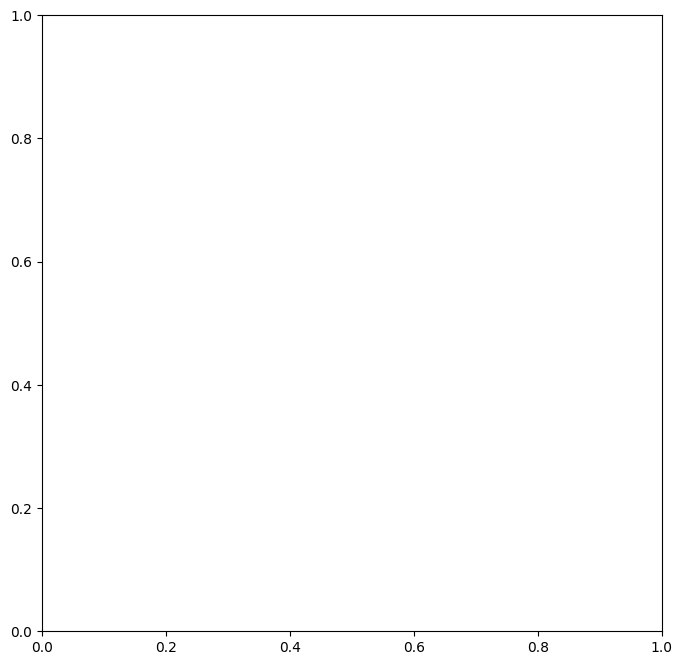

interactive(children=(IntSlider(value=0, description='Index:', max=2549), Output()), _dom_classes=('widget-int…

In [16]:
def plot_patches_on_demand(X, Y):
    def plot_patches(i):
        plt.figure(figsize=(6, 6))
        sl = slice(i,  (i + 1)), 0
        plot_some(X[sl], Y[sl], title_list=[np.arange(sl[0].start, sl[0].stop)], cmap= 'viridis')
        plt.show()

    i_slider = widgets.IntSlider(value=0, min=0, max=X.shape[0] -1, description='Index:')
    widgets.interact(plot_patches, i=i_slider)

plot_patches_on_demand(X, Y)

### Do the data augmentation
-   6 augmented image + 1 original image. 
-   data increases 7 times

In [ ]:
def viz_aug(X, Y):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    print(f'from visualizer : X {X.shape} {X.dtype}] : Y : {Y.shape} {Y.dtype} ')

    axes[0].imshow(X[...,1], cmap='viridis')
    axes[0].set_title('Augmented Image X')
    axes[0].axis('off')

    axes[1].imshow(Y, cmap='viridis')
    axes[1].set_title('Augmented Image Y')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()



def npz_info(file):
    npz_file = file

    try:
        data = np.load(npz_file)
    except IOError as e:
        print(f"Error loading .npz file: {e}")

    print(data)
    # Print the shape and dtype of each array in the .npz file
    for key in data.keys():
        print(f"{key} shape: {data[key].shape}, dtype: {data[key].dtype}")



def apply_augmentations_and_save(npz_file):
    try:
        data = np.load(npz_file)
    except IOError as e:
        print(f"Error loading .npz file: {e}")
        return
    
    if 'X' not in data or 'Y' not in data:
        print("Error: .npz file does not contain 'X' or 'Y' keys.")
        return
    #
    X = data['X']
    Y = data['Y']
    
    print(f"X shape before processing: {X.shape} {X.dtype}, Y shape before processing: {Y.shape} {Y.dtype}")

    augmented_X = []
    augmented_Y = []

    for i in range(X.shape[0]):
        ori_X = X[i, 0].transpose(1, 2, 0)
        ori_Y = Y[i, 0].transpose(1, 2, 0)
        print(f'checking original image shapes :ori_X {ori_X.shape} : ori_Y {ori_Y.shape}')
        augmented_X.append(np.expand_dims(ori_X.transpose(2, 0, 1),axis=0))
        augmented_Y.append(np.expand_dims(ori_Y.transpose(2, 0, 1),axis=0))

        for aug_fn in augmentations:
            print(f' augmentation input , X : {X[i, 0].transpose(1, 2, 0).shape} , Y : {Y[i, 0].transpose(1, 2, 0).shape}') # augmentation input , X : (128, 128, 9) , Y : (256, 256, 1)
            aug_X, aug_Y = aug_fn(X[i, 0].transpose(1, 2, 0), Y[i, 0].transpose(1, 2, 0))
            
            # for vizualizing the augmentation
            #viz_aug(aug_X, aug_Y)

            print(f'augmentation outoput: aug_X : {aug_X.shape} aug_Y : {aug_Y.shape} ') # augmentation outoput: aug_X : (128, 128, 9) aug_Y : (256, 256, 1) 
            print(f'being added to the array :aug_X.transpose(2, 0, 1) {aug_X.transpose(2, 0, 1).shape} : aug_Y.transpose(2, 0, 1) {aug_Y.transpose(2, 0, 1).shape}') #being added to the array :aug_X.transpose(2, 0, 1) (9, 128, 128) : aug_Y.transpose(2, 0, 1) (1, 256, 256)
            augmented_X.append(np.expand_dims(aug_X.transpose(2, 0, 1),axis=0))
            augmented_Y.append(np.expand_dims(aug_Y.transpose(2, 0, 1),axis=0))

    augmented_X = np.array(augmented_X)
    augmented_Y = np.array(augmented_Y)
    print(f'augmented_X : {augmented_X.shape} : augmented_Y:{augmented_Y.shape}') # augmented_X : (15300, 1, 9, 128, 128) : augmented_Y:(15300, 1, 1, 256, 256)
    directory_path = os.path.join(*npz_file.split('/')[:-1]) + '/'



    np.savez(directory_path + 'augmented_SR_Mictorubles.npz' X=augmented_X, Y=augmented_Y, axes=data['axes'])
    print(f"Augmented data saved to augmented_{npz_file}")
npz_file =  '../F-actin/Train/SR/microtubule_sr_training_data.npz'
apply_augmentations_and_save(npz_file)


### visualize the augmentation

In [2]:
def visualize_XY_from_npz(npz_file, num_samples):
    try:
        data = np.load(npz_file)
    except IOError as e:
        print(f"Error loading .npz file: {e}")
        return
    
    if 'X' not in data or 'Y' not in data:
        print("Error: .npz file does not contain 'X' or 'Y' keys.")
        return
    
    X = data['X']
    Y = data['Y']
    
    # Print shapes and data types for debugging
    # print(f"X shape before processing: {X.shape} {X.dtype}, Y shape before processing: {Y.shape} {Y.dtype}")
    # Example output: X shape before processing: (2550, 1, 9, 128, 128) float32, Y shape before processing: (2550, 1, 1, 256, 256) float32
    
    # Randomly select samples
    indices = np.random.choice(X.shape[0], num_samples, replace=False)
    X = X[indices]
    Y = Y[indices]
    
    fig, axes = plt.subplots(num_samples, len(augmentations) + 1, figsize=(20, num_samples * 5))  # Adjust figure size as needed
    
    for i in range(num_samples):
        X_img = X[i, 0, 0]  # First channel of X
        Y_img = Y[i, 0, 0]  # First channel of Y
        
        # Display original images
        axes[i, 0].imshow(X_img, cmap='viridis')
        axes[i, 0].set_title('Original Image X', fontsize=10)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(Y_img, cmap='viridis')
        axes[i, 1].set_title('Original Image Y', fontsize=10)
        axes[i, 1].axis('off')
        
        # Apply augmentations and display
        for j, (aug_name, aug_fn) in enumerate(augmentations):
            aug_X, aug_Y = aug_fn(X_img, Y_img)
            
            axes[i, j + 2].imshow(aug_X, cmap='viridis')
            axes[i, j + 2].set_title(f'{aug_name} Image X', fontsize=8)
            axes[i, j + 2].axis('off')

            axes[i, j + 3].imshow(aug_Y, cmap='viridis')
            axes[i, j + 3].set_title(f'{aug_name} Image Y', fontsize=8)
            axes[i, j + 3].axis('off')
        
    plt.tight_layout()
    plt.show()

# Example usage
npz_file = r'y:\F-actin\Train\SR\microtubule_sr_training_data.npz'  # Replace with your .npz file path
visualize_XY_from_npz( r'y:\F-actin\Train\SR\augmented_SR_Mictorubles.npz', 4)


..\F-actin\Train\SR/
